In [1]:
import os
import numpy as np 
import pandas as pd
import scipy
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
os.chdir('/kaggle/input/BloodPressureDataset')

# Heart Rate

In [3]:
def extract_heart_rate(ecg_signal, sampling_rate, min_hr, max_hr):
    num_samples = len(ecg_signal)
    fft_ecg = fft(ecg_signal)
    frequencies = fftfreq(num_samples, 1/fs)
    peaks_ecg, _ = find_peaks(np.abs(fft_ecg)[1:num_samples//2], distance=num_samples/fs)
    peak_index_ecg =  peaks_ecg[np.argsort(np.abs(fft_ecg[peaks_ecg]))[::-1][:3]]
    peak_frequencies = np.round(frequencies[peak_index_ecg],1)
    peak_frequency_ecg = [element for element in peak_frequencies if min_hr/60 <= element <= max_hr/60]
    if len(peak_frequency_ecg) > 0:
        heart_rate = 60 * float(min(peak_frequency_ecg))
    else:
        heart_rate = np.nan
    return heart_rate

In [4]:
fs = 125
heart_rates = []
for ii in range(12):
    filename = 'part_' + str(ii + 1) + '.mat'
    mat_data = scipy.io.loadmat(filename)['p']
    for jj in range(1000):
        ecg_signal = mat_data[0][jj][2]
        heart_rates.append(extract_heart_rate(ecg_signal, fs, min_hr= 30, max_hr=220))

Text(0, 0.5, 'Count')

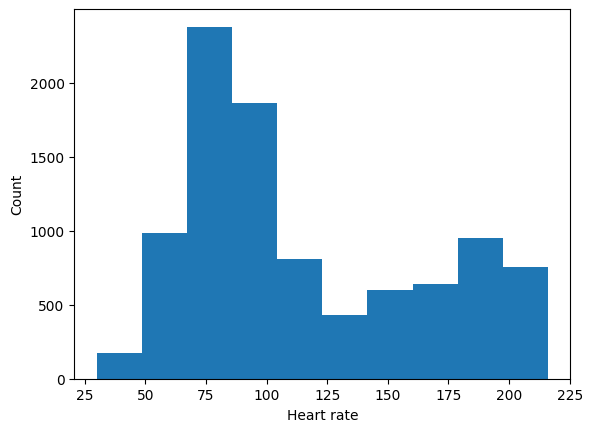

In [5]:
plt.hist(heart_rates)
plt.xlabel('Heart rate')
plt.ylabel('Count')